In [11]:
# !pip install -U transformers , datasets , torch , tqdm

In [28]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [14]:
# Load model and tokenizer
print("\nLoading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("markusleonardo/DistilRoBERTa-For-Semantic-Similarity")
model = AutoModelForSequenceClassification.from_pretrained("markusleonardo/DistilRoBERTa-For-Semantic-Similarity")
model = model.to(device)
model.eval()


Loading model and tokenizer...


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [15]:
# Load dataset
print("Loading ANLI dataset...")
ds = load_dataset("facebook/anli")
test = ds['test_r2']

# Preprocess test set
print("Preprocessing test set...")
test = test.map(lambda x: {
    'premise': x['premise'].lower(),
    'hypothesis': x['hypothesis'].lower()
})


Loading ANLI dataset...
Preprocessing test set...


In [16]:
def prepare_batch(batch):
    """Tokenize a batch of premise-hypothesis pairs with instructions"""
    # Add task instruction and format labels
    premises_with_instruction = [
        f"Determine if the hypothesis follows from the premise. Premise: {premise}"
        for premise in batch['premise']
    ]
    hypotheses_with_label = [
        f"Hypothesis: {hypothesis}"
        for hypothesis in batch['hypothesis']
    ]

    inputs = tokenizer(
        premises_with_instruction,
        hypotheses_with_label,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    return inputs

In [21]:
# Get predictions
print("\nRunning inference on test set...")
batch_size = 32
all_predictions = []
all_labels = []

# Create batches manually
for i in tqdm(range(0, len(test), batch_size)):
    batch = test[i:i+batch_size]

    # Add task instruction and format labels
    premises_with_instruction = [
        f"Determine if the hypothesis follows from the premise.\n\n Premise: {premise}"
        for premise in batch['premise']
    ]
    hypotheses_with_label = [
        f"Hypothesis: {hypothesis}"
        for hypothesis in batch['hypothesis']
    ]

    # Tokenize batch
    inputs = tokenizer(
        premises_with_instruction,
        hypotheses_with_label,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(batch['label'])


Running inference on test set...


100%|██████████| 32/32 [00:04<00:00,  7.13it/s]


In [22]:
# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Generate classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT ON ANLI TEST SET (R2)")
print("="*60)

# Label mapping for ANLI
label_names = ['entailment', 'neutral', 'contradiction']

report = classification_report(
    all_labels,
    all_predictions,
    target_names=label_names,
    digits=4
)

print(report)


CLASSIFICATION REPORT ON ANLI TEST SET (R2)
               precision    recall  f1-score   support

   entailment     0.4500    0.0269    0.0508       334
      neutral     0.3314    0.8468    0.4764       333
contradiction     0.3566    0.1381    0.1991       333

     accuracy                         0.3370      1000
    macro avg     0.3793    0.3373    0.2421      1000
 weighted avg     0.3794    0.3370    0.2419      1000



In [23]:
# Additional metrics
accuracy = (all_predictions == all_labels).mean()
print(f"\nOverall Accuracy: {accuracy:.4f}")


Overall Accuracy: 0.3370


In [24]:
# Per-class accuracy
print("\nPer-class counts:")
for i, label in enumerate(label_names):
    true_count = (all_labels == i).sum()
    pred_count = (all_predictions == i).sum()
    correct = ((all_labels == i) & (all_predictions == i)).sum()
    print(f"{label:15s}: {correct:4d}/{true_count:4d} correct (predicted: {pred_count:4d})")


Per-class counts:
entailment     :    9/ 334 correct (predicted:   20)
neutral        :  282/ 333 correct (predicted:  851)
contradiction  :   46/ 333 correct (predicted:  129)



Generating confusion matrix...
Confusion matrix saved as 'confusion_matrix_anli_r2.png'


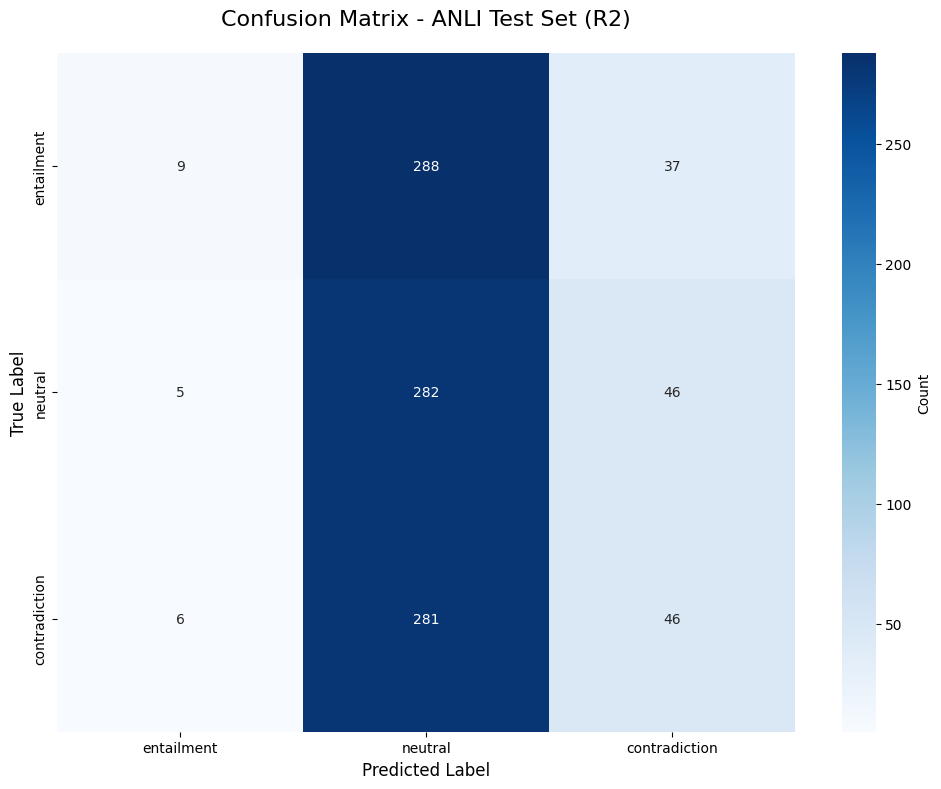

Normalized confusion matrix saved as 'confusion_matrix_normalized_anli_r2.png'


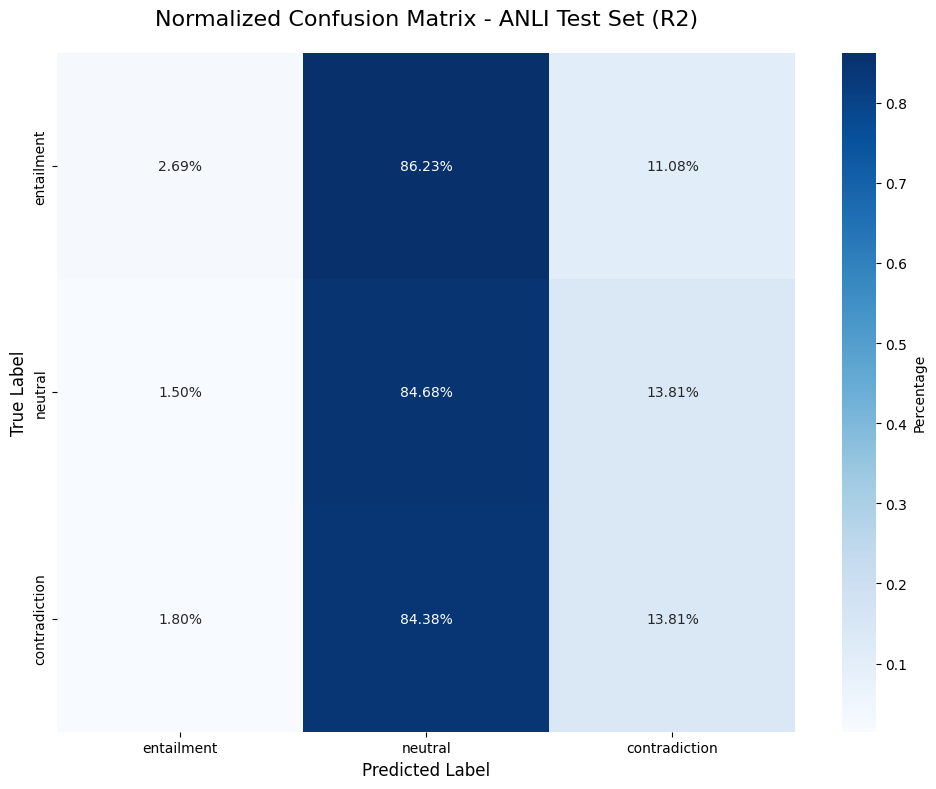

In [29]:
print("\nGenerating confusion matrix...")
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - ANLI Test Set (R2)', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig('confusion_matrix_anli_r2.png', dpi=300, bbox_inches='tight')
print("Confusion matrix saved as 'confusion_matrix_anli_r2.png'")
plt.show()

# Also plot normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix - ANLI Test Set (R2)', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

# Save the normalized plot
plt.savefig('confusion_matrix_normalized_anli_r2.png', dpi=300, bbox_inches='tight')
print("Normalized confusion matrix saved as 'confusion_matrix_normalized_anli_r2.png'")
plt.show()